# Análise Inferencial e Seleção de Atributos (Matemática)

> Objetivo: Realizar uma análise inferencial e uma seleção criteriosa de atributos com base em testes estatísticos, análise de multicolinearidade e regressões lineares, a fim de identificar os fatores mais relevantes para o desempenho acadêmico em Matemática.


#### Configurações Iniciais

###### ajustar o path

In [1]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

## 1. Bibliotecas, Módulos e Configurações Iniciais

In [2]:
#Importação dos módulos desenvolvidos

from modulos.pre_modelagem import importar_base, preparar_dados
from modulos.eda_functions import *
from modulos.feature_selection import( ajustar_regressao,
                                       stepwise_selection,
                                       avaliar_residuos_regressao,
                                       selecionar_nominais_relevantes,
                                       selecionar_ordinais_relevantes,
                                       relatorio_multicolinearidade,
                                       regressao_multipla,
                                       comparar_modelos_regressao
                                       
                                     )

# Bibliotecas

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
import shap

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')


# 1. Importação da Base e Pré-Modelagem

In [3]:
#Importação da base

materia =  'matematica' 

cor_paleta = 'verde' 

# Trabalhando apenas com o conjunto de treino (df_t)
# para evitar qualquer tipo de vazamento de dados nas etapas de análise inferencial e seleção de atributos

df_t = pd.read_csv('data\dados_treino_matematica_rs42.csv')

df = df_t.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276 entries, 0 to 275
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   escola                        276 non-null    object
 1   genero                        276 non-null    object
 2   idade                         276 non-null    int64 
 3   endereco                      276 non-null    object
 4   tamanho_familia               276 non-null    object
 5   status_parental               276 non-null    object
 6   escolaridade_mae              276 non-null    int64 
 7   escolaridade_pai              276 non-null    int64 
 8   profissao_mae                 276 non-null    object
 9   profissao_pai                 276 non-null    object
 10  motivo_escolha_escola         276 non-null    object
 11  responsavel_legal             276 non-null    object
 12  tempo_transporte              276 non-null    int64 
 13  tempo_estudo        

# 2. Síntese Inicial com Base na EDA

A EDA foi conduzida exclusivamente no conjunto de treinamento da base de Matemática, com o objetivo de gerar hipóteses preliminares sobre atributos potencialmente relevantes. Os achados listados a seguir orientam, mas **não determinam**, as escolhas de atributos para modelagem. A formalização será feita através de análises inferenciais neste notebook.

- As variáveis de nota apresentaram **distribuições não normais** (teste de Shapiro-Wilk).
- Certas variáveis categóricas demonstraram **associação visual com aprovação**, sugerindo possível relação com o desempenho.
- A **multicolinearidade será avaliada** com VIF e análise de correlação entre preditores.



In [5]:
selecao_eda_mat = [
    "faltas", "idade",
    "reprovacoes", "tempo_estudo", "interesse_ensino_superior",
    "escolaridade_mae", "alcool_dias_uteis", "frequencia_saidas",
    "tempo_transporte", "relacao_familiar", "responsavel_legal",
    "apoio_escolar", "acesso_internet"
]

# 3. Avaliação de Multicolinearidade

A multicolinearidade ocorre quando dois ou mais preditores apresentam alta correlação entre si, o que pode dificultar a interpretação dos coeficientes em modelos lineares, inflar os erros padrão e comprometer a estabilidade estatística.

Nesta etapa, avaliamos a presença de multicolinearidade entre os preditores por meio de:

- **Coeficiente de correlação de Pearson** entre pares de variáveis (limite: |r| > 0.6).
- **Fator de Inflação da Variância (VIF)**, com foco em VIF > 5 (alerta) e VIF > 10 (crítico).

> ###### *Todos os cálculos são realizados **apenas no conjunto de treino**, conforme boas práticas para evitar vazamento de dados.*


In [6]:
# Pré-processamento: remoção da variável-alvo e preparação dos dados
variaveis_target = ['nota1', 'nota2', 'nota_final']

# Garante que apenas preditores sejam analisados
df_pp = preparar_dados(df, columns_to_drop=['aprovacao'])  # df é o conjunto de treino
df_preditores = df_pp.drop(columns=variaveis_target)

# Avaliação de multicolinearidade
print('Limiar coeficiente de correlação > 0.6')
resumo, vif_df = relatorio_multicolinearidade(df_preditores, limite_corr=0.6)

# Mostra apenas os casos com alerta
display(resumo[resumo['avaliacao'] != 'Sem alerta'])



Removendo colunas: ['aprovacao']
Shape final do DataFrame preparado: (276, 42)
Limiar coeficiente de correlação > 0.6


,variavel_1,variavel_2,correlacao
5,escolaridade_pai,escolaridade_mae,0.657937
189,alcool_fim_semana,alcool_dias_uteis,0.631474
526,profissao_pai_Serviços,profissao_pai_Outra profissão,0.685917


,variavel,vif,Alta correlação com,avaliacao
0,idade,90.282730,—,VIF elevado
2,escolaridade_mae,24.139221,escolaridade_pai,VIF alto + correlação alta
15,relacao_familiar,24.060316,—,VIF elevado
12,interesse_ensino_superior,23.098282,—,VIF elevado
30,profissao_pai_Outra profissão,15.983847,profissao_pai_Serviços,VIF alto + correlação alta
3,escolaridade_pai,15.843645,escolaridade_mae,VIF alto + correlação alta
16,tempo_livre,14.943433,—,VIF elevado
17,frequencia_saidas,12.477471,—,VIF elevado
5,tempo_estudo,10.407659,—,VIF elevado
19,alcool_fim_semana,9.510094,alcool_dias_uteis,VIF alto + correlação alta


> ### Principais achados
> 
> - Foram identificados **três pares de variáveis com correlação superior a 0,60**, indicando redundância potencial:
>   - `escolaridade_pai` e `escolaridade_mae` (r = 0,66)
>   - `alcool_fim_semana` e `alcool_dias_uteis` (r = 0,63)
>   - `profissao_pai_Serviços` e `profissao_pai_Outra profissão` (r = 0,69)
>
> - **Vinte e seis variáveis apresentaram VIF acima de 5**, sendo que **oito ultrapassaram o limiar crítico de 10**. Destacam-se:
>   - `idade` (VIF = 90,28)
>   - `escolaridade_mae` e `escolaridade_pai` (ambas com VIFs > 15 e correlação alta entre si)
>   - `relacao_familiar`, `tempo_livre`, `frequencia_saidas`, `tempo_estudo`, `interesse_ensino_superior` (VIFs entre 10–24)
>   - `alcool_dias_uteis` e `alcool_fim_semana` (VIFs entre 8–9), com correlação mútua elevada
>
> - Algumas variáveis foram **mantidas apesar do VIF elevado**, com base em critérios de interpretabilidade e relevância teórica:
>   - `escolaridade_mae` (mantida em detrimento da variável paterna)
>   - `alcool_dias_uteis` (preferida ao uso no fim de semana)
>   - `interesse_ensino_superior` e `frequentou_creche` (relacionadas a contexto educacional)
>
> - Foram apontadas como **candidatas à remoção por redundância estatística**:
>   - `escolaridade_pai`, `alcool_fim_semana`, `profissao_pai_Outra profissão` e `profissao_pai_Serviços`
>
> Essas considerações orientam a etapa seguinte de regressão, priorizando parcimônia, estabilidade estatística e coerência com o contexto educacional analisado.



In [7]:
variaveis_alta_colineariedade_descarte = [
            'escolaridade_pai',
            'alcool_fim_semana',
            'profissao_pai_Outra profissão',
            'profissao_pai_Serviços'
        ]
variaveis_alta_colineariedade = [
            'escolaridade_pai',
            'escolaridade_mae',
            'alcool_fim_semana',
            'alcool_dias_uteis',
            'profissao_pai_Outra profissão',
            'profissao_pai_Serviços'
        ]

In [8]:
corr = df_pp[variaveis_alta_colineariedade + variaveis_target].corr()

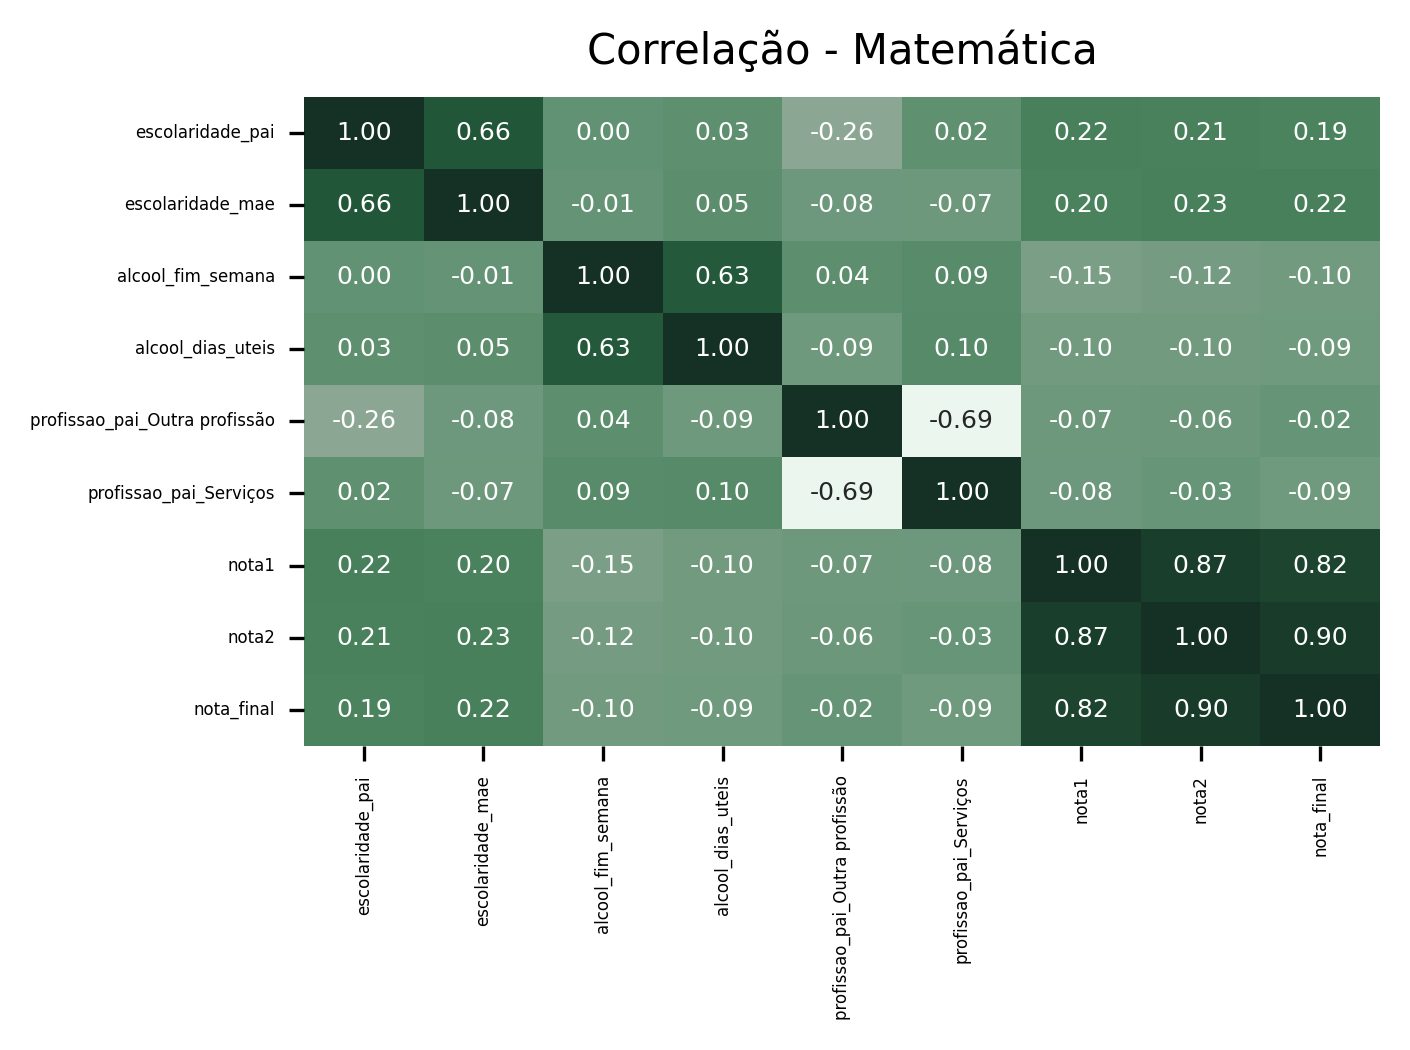

In [9]:
custom_heatmap(disciplina=materia,cores=cor_paleta,matriz_corr=corr, n_arq='corr_multicol',titulo='Correlação')

O mapa de calor confirma os padrões de colinearidade identificados numericamente:
>
> - `profissao_pai_Serviços` e `profissao_pai_Outra profissão` apresentam **correlação fortemente negativa** (-0,69), indicando possível redundância entre essas categorias dummies.
> - `escolaridade_pai` e `escolaridade_mae` possuem **correlação moderada-alta** (r = 0,66), sinalizando interdependência entre os níveis educacionais dos responsáveis.
> - `alcool_fim_semana` e `alcool_dias_uteis` exibem **correlação positiva relevante** (r = 0,63), indicando padrão consistente no consumo de álcool ao longo da semana.
> - As variáveis de desempenho escolar — `nota1`, `nota2` e `nota_final` — apresentam **correlação muito alta entre si** (todas acima de 0,82), o que é esperado pela progressão das notas ao longo do período letivo.
>
> Esses achados reforçam a necessidade de controle de multicolinearidade nos modelos de regressão e seleção cuidadosa de variáveis para modelagem preditiva.

# 4. Regressão: Da Nota 1 à Nota 2 – Avaliação de Fatores Explicativos

Esta seção busca investigar os fatores associados à nota intermediária (`nota2`) por meio de modelos de regressão linear. Inicialmente, avaliamos o impacto isolado da `nota1`, seguida da inclusão de variáveis contextuais e socioeducacionais com base nos atributos do conjunto de treino.

As etapas incluem:

- Regressão simples: `nota1` como único preditor.
- Regressão múltipla com variáveis selecionadas por diferentes critérios (p-valor, stepwise, VIF).
- Avaliação dos resíduos e suposições do modelo.
- Comparação entre os modelos quanto ao desempenho e parcimônia.



## 4.1. Modelo simples (nota1)
- Objetivo: Verificar a relação direta entre nota1 e nota2.
- Avaliar o comportamento dos coeficientes e resíduos.

In [10]:
#Pré processamento

df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota_final'],target_column='nota2')

Removendo colunas: ['aprovacao', 'nota_final']
Shape final do DataFrame preparado: (276, 41)


In [11]:
modelo_n2_1, X_wc, y = regressao_multipla(df_pp, target='nota2', variaveis=['nota1'])

## 4.2. Regressão múltipla com nota1 e variáveis adicionais

**Objetivo:** Avaliar a estabilidade do coeficiente associado à `nota1` na presença de outros preditores e identificar covariáveis explicativas adicionais associadas ao desempenho na `nota2`.


### 4.2.1 Modelo completo (sem seleção de atributos)
Foi ajustado um modelo com todas as variáveis disponíveis, exceto a variável-alvo `nota2`.


In [12]:
# Ajuste do modelo completo (sem seleção de atributos)
aux_drop = ['nota2']
variaveis_completas = list(set(df_pp.columns) - set(aux_drop))

modelo_n2_2, X_completo, y_completo = regressao_multipla(
    df_pp,
    target='nota2',
    variaveis=variaveis_completas
)



### 4.2.2 Seleção dos 15 atributos com menor p-valor
Com base no modelo completo, selecionou-se as 15 variáveis com menor p-valor.


In [13]:
X_top15, y_top15, modelo_top15, top_15_var = ajustar_regressao(
    df=df_pp,
    target_column='nota2',
    top_n=15
)


--- Sumário do Modelo de Regressão OLS ---
                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     25.63
Date:                Wed, 14 May 2025   Prob (F-statistic):           3.35e-65
Time:                        22:44:36   Log-Likelihood:                -521.31
No. Observations:                 276   AIC:                             1125.
Df Residuals:                     235   BIC:                             1273.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

,Coef.,Std.Err.,t,P>|t|
nota1,0.957,0.039,24.422,2.04e-66
idade,-0.315,0.119,-2.654,0.008
escolaridade_mae,0.345,0.174,1.983,0.049
relacionamento_romantico,-0.445,0.242,-1.839,0.067
motivo_escolha_escola_Outro motivo,0.723,0.413,1.750,0.081
reprovacoes,-0.326,0.187,-1.746,0.082
endereco_Urbano,0.517,0.307,1.683,0.094
tamanho_familia,-0.414,0.249,-1.667,0.097
aulas_particulares,0.380,0.244,1.556,0.121
tempo_transporte,-0.289,0.192,-1.504,0.134


-----------------------------------------------

Atributos de maior relevância (por P-valor):
1. nota1
2. idade
3. escolaridade_mae
4. relacionamento_romantico
5. motivo_escolha_escola_Outro motivo
6. reprovacoes
7. endereco_Urbano
8. tamanho_familia
9. aulas_particulares
10. tempo_transporte
11. alcool_dias_uteis
12. escola_Mousinho da Silveira
13. alcool_fim_semana
14. profissao_mae_Outra profissão
15. genero_Mulher


In [14]:
# Ajuste da regressão com os 15 atributos mais relevantes por p-valor
variaveis_15 = top_15_var
target = 'nota2'

modelo_n2_3, X_top15, y_top15 = regressao_multipla(df_pp[variaveis_15 + [target]], 
                                                   target=target, 
                                                   variaveis=variaveis_15)



### 4.2.3 Ajustes por multicolinearidade

A partir dos 15 atributos, foram removidas variáveis redundantes estatisticamente, como:

- `escolaridade_pai` (mantida a materna por valor teórico),
- `profissao_pai_Serviços` (avaliada isoladamente com e sem `profissao_pai_Outra profissão`).

Também foi testada a **inclusão específica da variável `faltas`**, dada sua relevância observada em análises anteriores, mesmo não aparecendo entre os 15 menores p-valores iniciais.

In [15]:
# Identificação das variáveis colineares entre os 15 melhores atributos
colineares_top15 = list(set(top_15_var) & set(variaveis_alta_colineariedade))
print("Variáveis com alta colinearidade dentro do top 15:", colineares_top15)

# Modelo com exclusão de variáveis colineares (ex: profissao_pai_Outra profissão)
variaveis_sem_colinear = list(set(top_15_var) - set(['profissao_pai_Outra profissão']))

modelo_n2_4, X_n2_4, y_n2_4 = regressao_multipla(
    df=df_pp[variaveis_sem_colinear + ['nota2']],
    target='nota2',
    variaveis=variaveis_sem_colinear
)



Variáveis com alta colinearidade dentro do top 15: ['alcool_fim_semana', 'escolaridade_mae', 'alcool_dias_uteis']


In [16]:
# Modelo com inclusão manual da variável 'faltas' (avaliada previamente como relevante)
variaveis_com_faltas = variaveis_sem_colinear + ['faltas']

modelo_n2_5, X_n2_5, y_n2_5 = regressao_multipla(
    df=df_pp[variaveis_com_faltas + ['nota2']],
    target='nota2',
    variaveis=variaveis_com_faltas
)




### 4.2.4 Seleção stepwise (AIC e BIC)

Aplicou-se seleção stepwise com critérios AIC e BIC

In [17]:
variaveis_sem_nota = df_pp.drop(columns='nota2').columns


features_aic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='aic',
    verbose=True 
)

features_bic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='bic',
    verbose=True 
)



# Combinação das variáveis selecionadas por AIC e BIC, sem repetição
from itertools import chain

seen = set()
variaveis_step = []

for item in chain(features_aic, features_bic):
    if item not in seen:
        seen.add(item)
        variaveis_step.append(item)


Critério inicial (AIC): 1508.1288
Adicionada: nota1 (AIC=1115.4673)
Adicionada: idade (AIC=1095.1391)
Adicionada: reprovacoes (AIC=1090.3840)
Adicionada: endereco_Urbano (AIC=1088.0269)
Adicionada: profissao_pai_Serviços (AIC=1086.6409)
Adicionada: motivo_escolha_escola_Outro motivo (AIC=1086.2953)
Adicionada: profissao_pai_Professor(a) (AIC=1085.5720)
Adicionada: profissao_mae_Outra profissão (AIC=1085.4949)
Adicionada: relacionamento_romantico (AIC=1085.0093)
Removida: profissao_pai_Professor(a) (Novo AIC=1084.9044)
Adicionada: aulas_particulares (AIC=1083.8062)
Adicionada: tamanho_familia (AIC=1083.7664)

Variáveis selecionadas final (aic): ['nota1', 'idade', 'reprovacoes', 'endereco_Urbano', 'profissao_pai_Serviços', 'motivo_escolha_escola_Outro motivo', 'profissao_mae_Outra profissão', 'relacionamento_romantico', 'aulas_particulares', 'tamanho_familia']
Critério inicial (BIC): 1511.7492
Adicionada: nota1 (BIC=1122.7081)
Adicionada: idade (BIC=1106.0003)
Adicionada: reprovacoes (BI

In [18]:
modelo_step, X_step, y_step = regressao_multipla(
    df=df_pp[variaveis_step + ['nota2']],
    target='nota2',
    variaveis=variaveis_step
)


#### **Resumo com todos os Modelos**

In [19]:
modelos_ols = [
    modelo_n2_1,  # Regressão simples
    modelo_n2_2,  # Completo
    modelo_n2_3,  # Top 15
    modelo_n2_4,  # Sem colineares
    modelo_n2_5,  # + faltas
    modelo_step   # Stepwise
]

nomes_modelos = [
    'Regressão Simples (nota2 ~ nota1)',
    'Regressão Múltipla Completa (sem seleção)',
    'Regressão Múltipla (Top 15 p-valores)',
    'Regressão Ajustada (sem colineares)',
    'Regressão Ajustada + Faltas',
    'Regressão Stepwise (AIC + BIC)'
]


### 4.2.5 Diagnóstico dos Modelos de Regressão


#### **Principais achados**

- A regressão simples (`nota2 ~ nota1`) apresentou desempenho elevado (R² ajustado = 0,760), com `nota1` se consolidando como o principal preditor isolado da `nota2`.

- O modelo completo, embora com R² ajustado superior (0,782), envolveu 40 variáveis e apenas 3 estatisticamente significativas, evidenciando sobreajuste e baixa parcimônia.

- Modelos reduzidos com base nos menores p-valores e após remoção de colinearidade mantiveram desempenho semelhante (R² ajustado ≈ 0,790), indicando boa robustez com menos atributos.

- A inclusão da variável `faltas` não alterou significativamente o ajuste, embora seu papel possa ser retomado por critérios interpretativos.

- O **modelo stepwise** apresentou o melhor equilíbrio entre desempenho e simplicidade:
  - R² ajustado de **0,793**
  - **Menor AIC (1083)** e RMSE (≈1,69)
  - **Maior número de variáveis significativas** (6 entre 10)


#### **Interpretação adicional**

- `nota1` foi estatisticamente significativa (p < 0.001) em todos os modelos, com coeficiente em torno de 0.94.

- `idade` e `reprovacoes` mantiveram significância em diversos ajustes, destacando-se como fatores consistentes associados ao desempenho.

- A presença recorrente de variáveis como `endereco_Urbano`, `profissao_mae_Outra profissão`, `relacionamento_romantico` e `aulas_particulares` sugere possíveis contribuições contextuais relevantes, ainda que com efeitos menores.




In [20]:

comparar_modelos_regressao(
    modelos=modelos_ols, nomes = nomes_modelos
)


,Modelo,R²,R² Ajustado,AIC,BIC,Log-Likelihood,F-statistic,RMSE,Nº Variáveis,Variáveis Significativas (p<0.05)
0,Regressão Simples (nota2 ~ nota1),0.760675,0.759802,1115.467307,1122.708108,-555.733653,870.886744,1.818888,1,1
1,Regressão Múltipla Completa (sem seleção),0.813517,0.781775,1124.610633,1273.047068,-521.305316,25.629162,1.733698,40,3
2,Regressão Múltipla (Top 15 p-valores),0.801925,0.790497,1091.254713,1149.181127,-529.627356,70.175556,1.698696,15,3
3,Regressão Ajustada (sem colineares),0.801925,0.790497,1091.254713,1149.181127,-529.627356,70.175556,1.698696,15,3
4,Regressão Ajustada + Faltas,0.802305,0.790092,1092.724421,1154.271236,-529.362210,65.693719,1.700338,16,3
5,Regressão Stepwise (AIC + BIC),0.800114,0.792571,1083.766440,1123.590850,-530.883220,106.075624,1.690268,10,6


In [21]:

#detalhamento
for i, modelo in enumerate(modelos_ols, start=1):
    print(f"\n--- Modelo {i} ---")
    print(modelo.summary())



--- Modelo 1 ---
                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     870.9
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.60e-87
Time:                        22:44:38   Log-Likelihood:                -555.73
No. Observations:                 276   AIC:                             1115.
Df Residuals:                     274   BIC:                             1123.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1494      0.376  

### 4.2.6 Avaliação de Resíduos e Comparação de Modelos

A análise gráfica e estatística dos resíduos buscou verificar a adequação dos modelos ajustados às premissas da regressão linear. Todos os modelos apresentaram resíduos com média próxima de zero, ausência de autocorrelação (Durbin-Watson ≈ 1,91) e número moderado de outliers (≈4 a 5 casos).

Por outro lado, foi constatada violação sistemática da **normalidade** dos resíduos (p < 0.001 no teste de Shapiro-Wilk) e **heterocedasticidade** (p < 0.05 no teste de Breusch-Pagan), indicando que as premissas clássicas da regressão não foram plenamente atendidas.

Visualmente, o **Modelo 1 (simples)** apresentou maior dispersão e assimetria nos resíduos, com maior concentração de valores extremos negativos. Já os **Modelos 4, 5 e Stepwise** demonstraram maior simetria, menor amplitude e melhor aderência visual à normalidade.

O **modelo Stepwise**, além de apresentar métricas superiores de ajuste, também se destacou pela estabilidade dos resíduos, reforçando sua adequação como modelo final para explicar a `nota2` na base de Matemática.



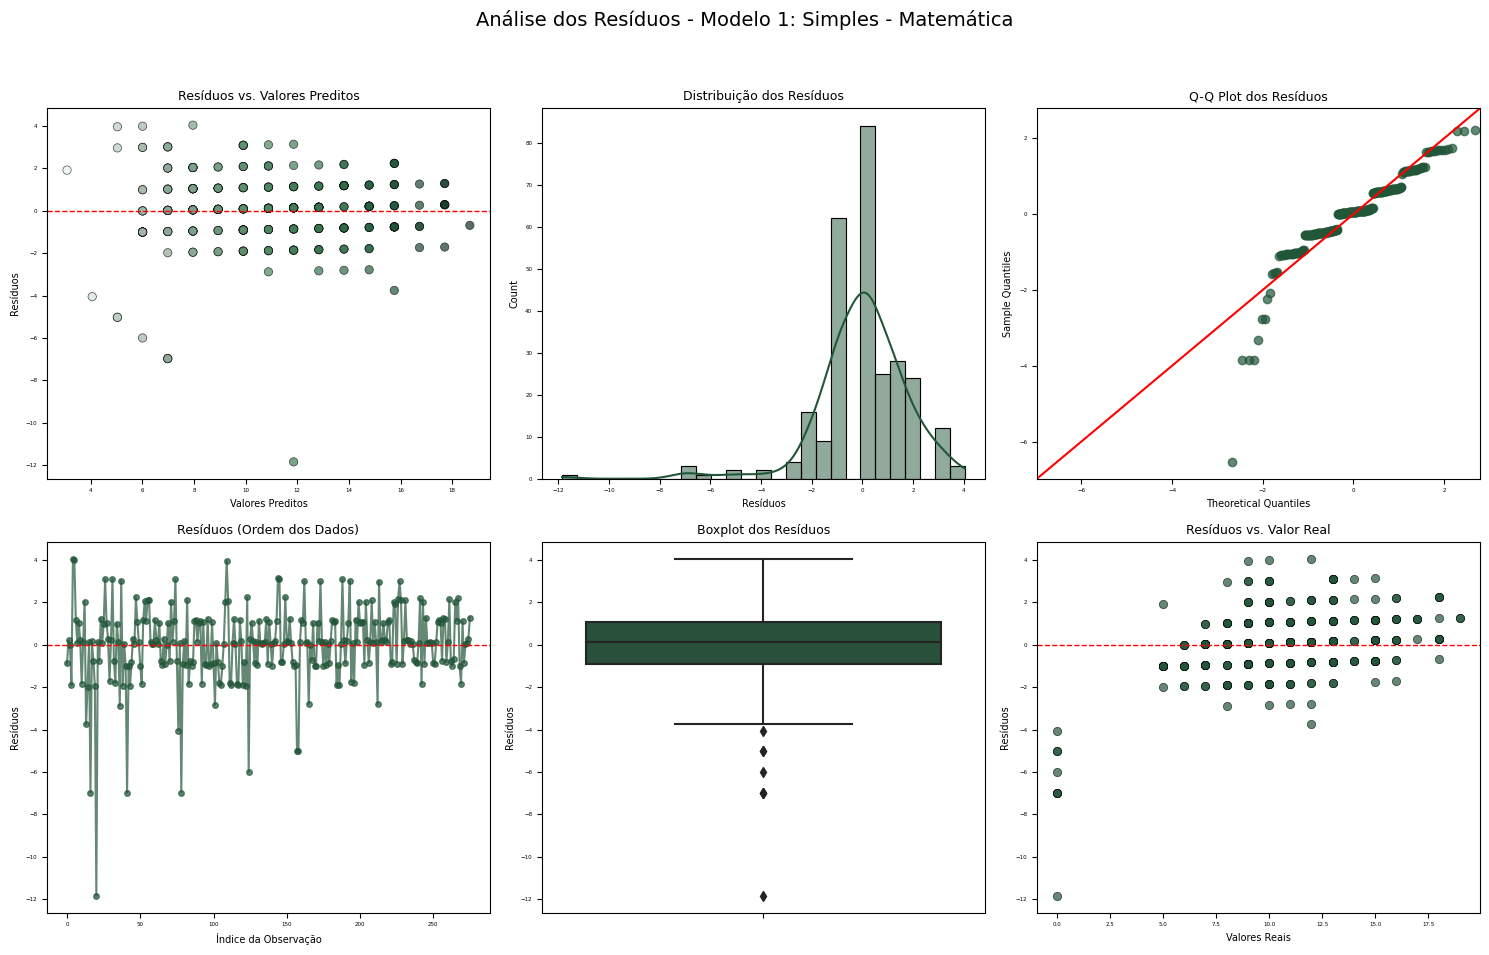

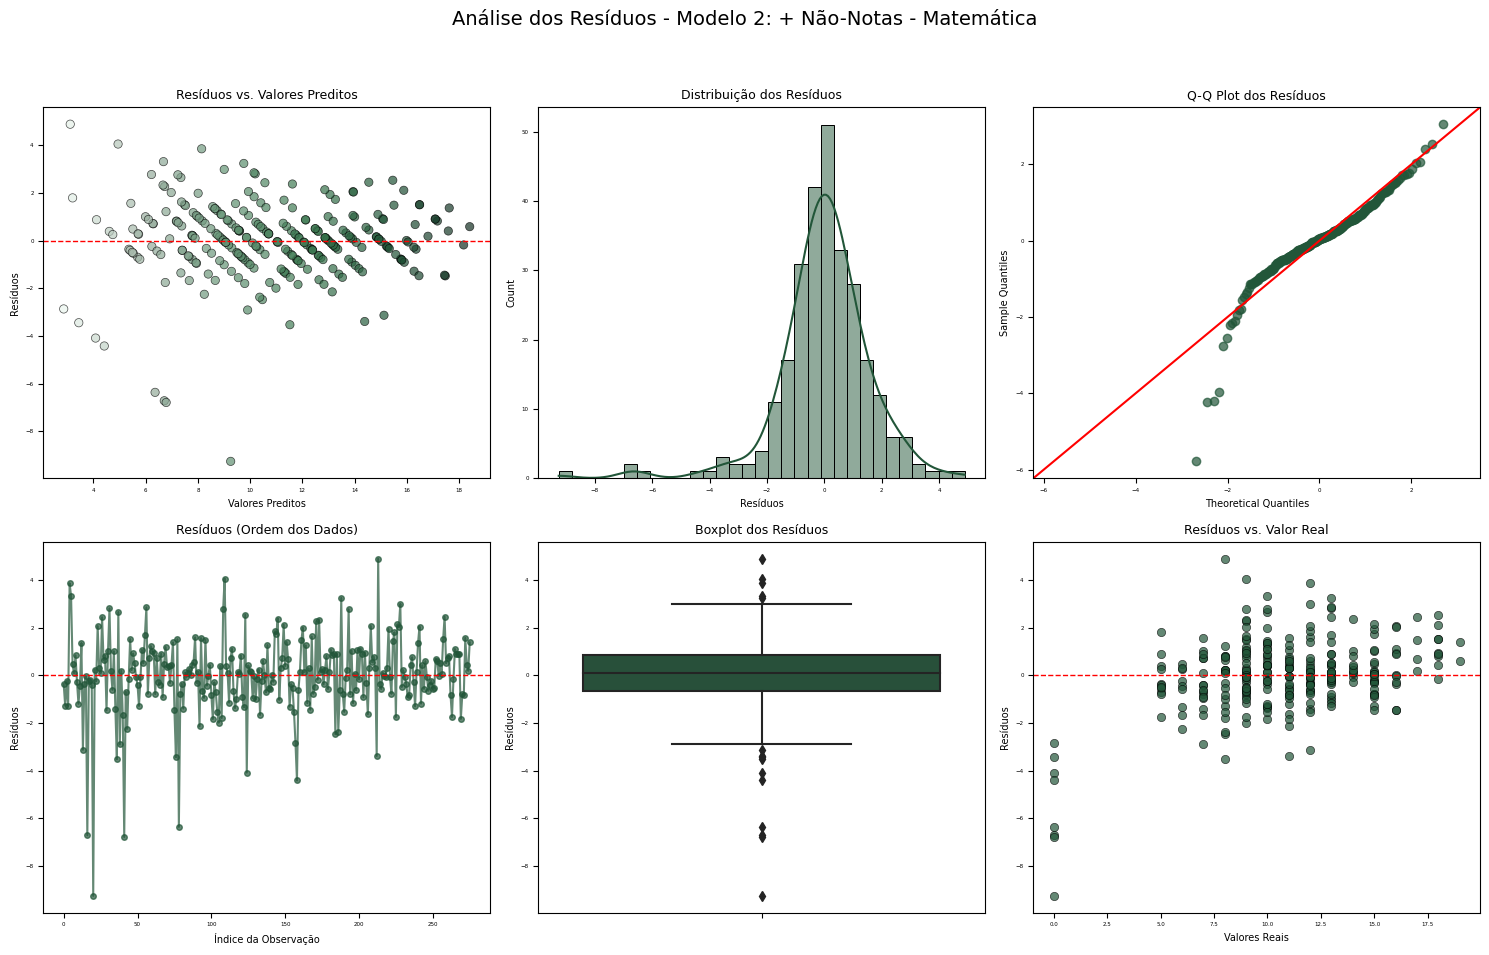

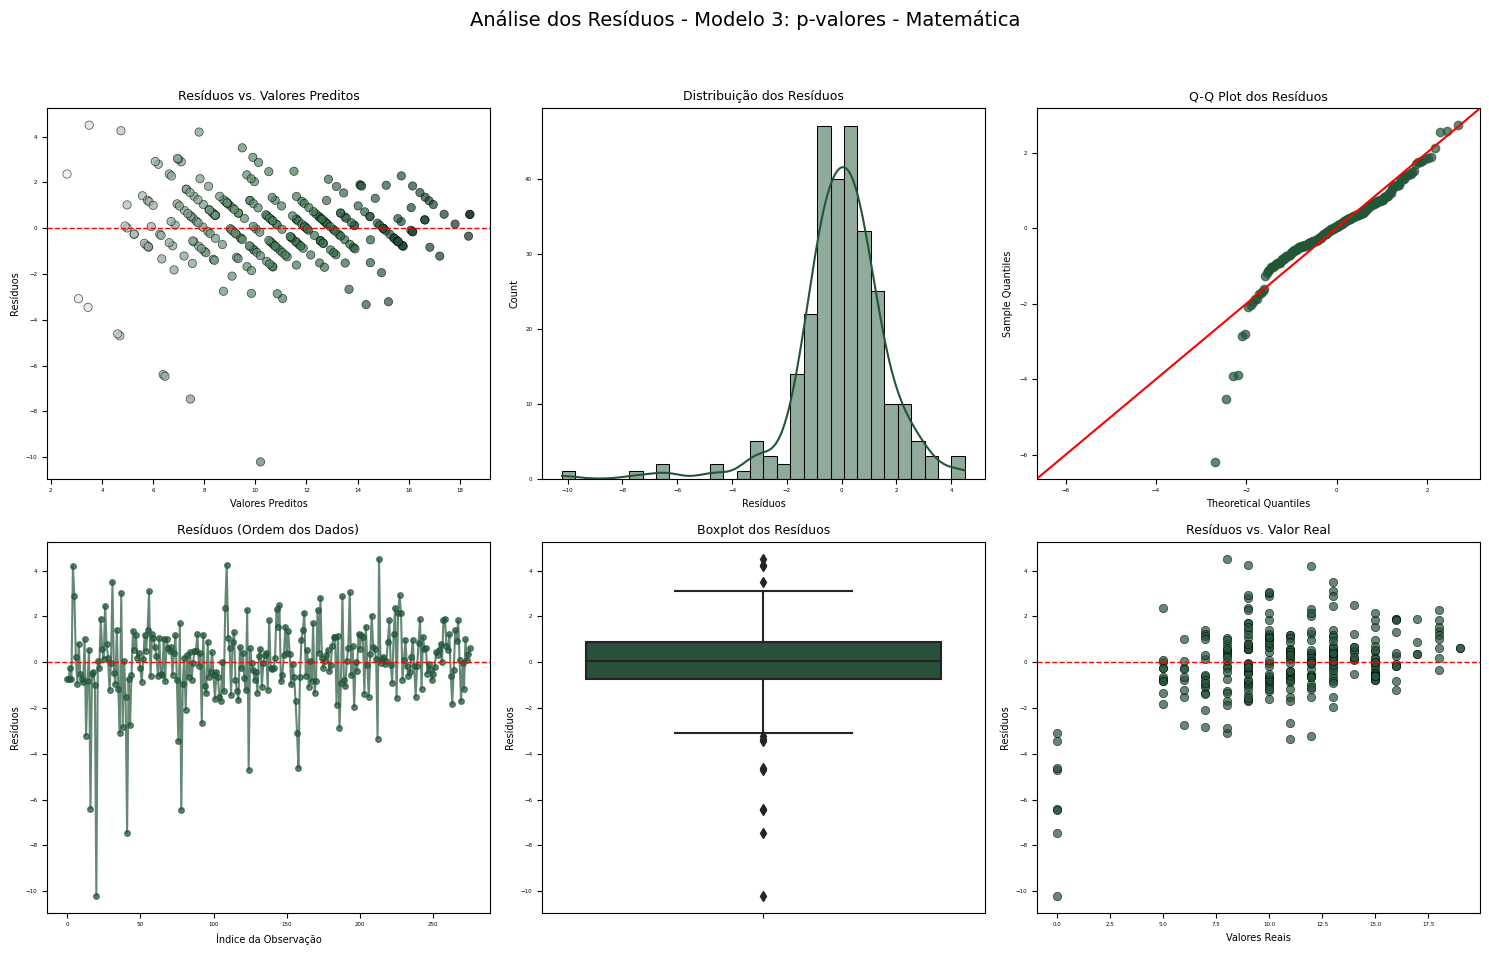

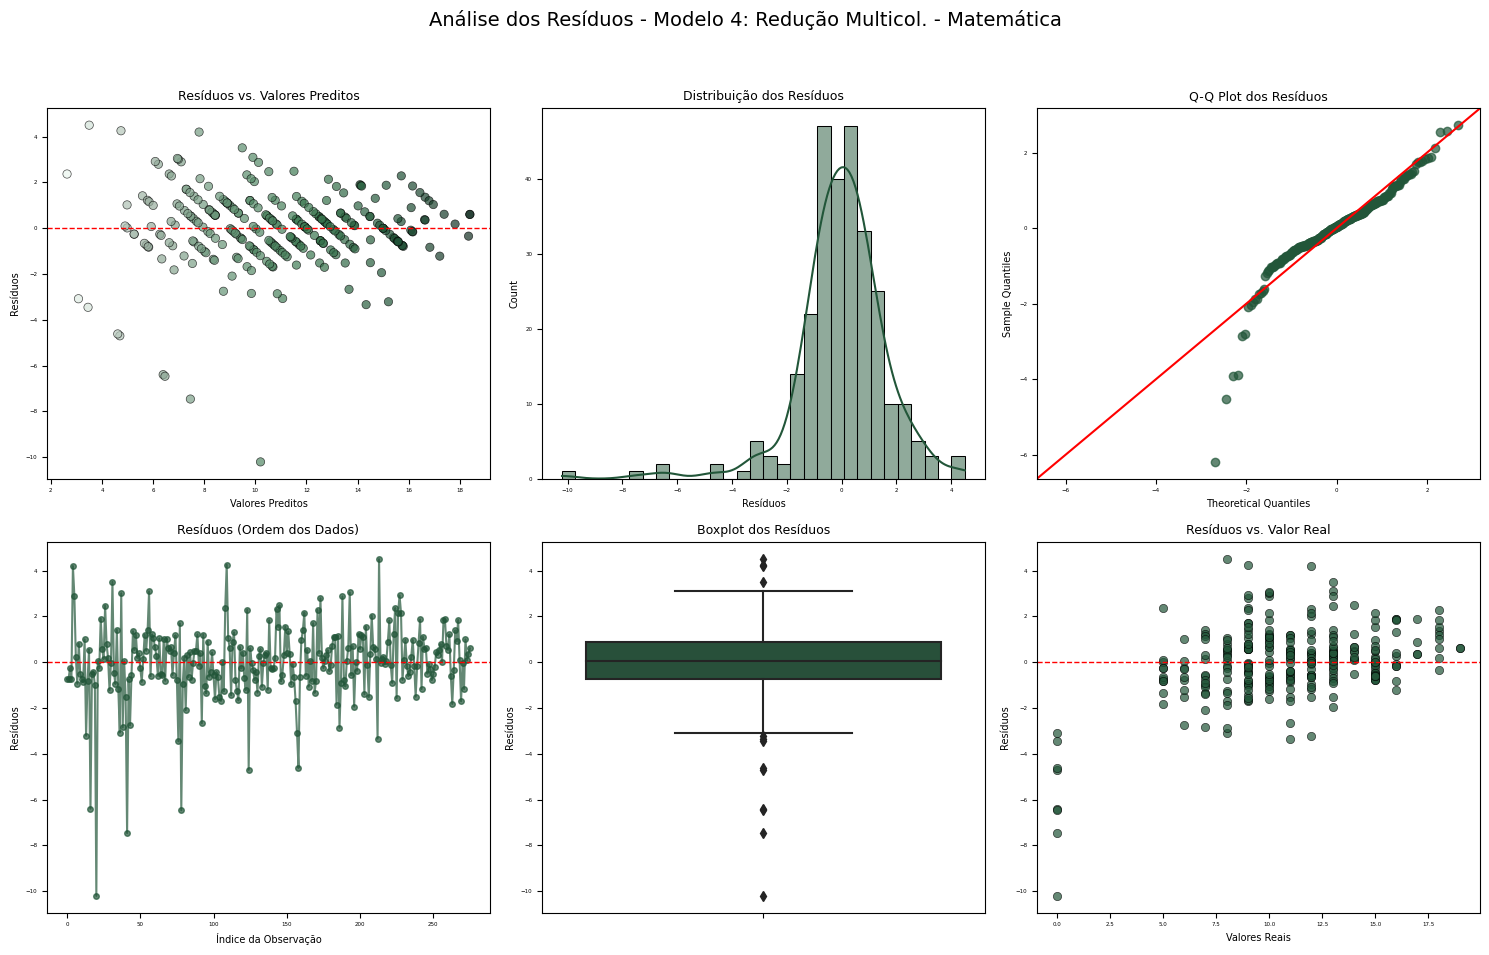

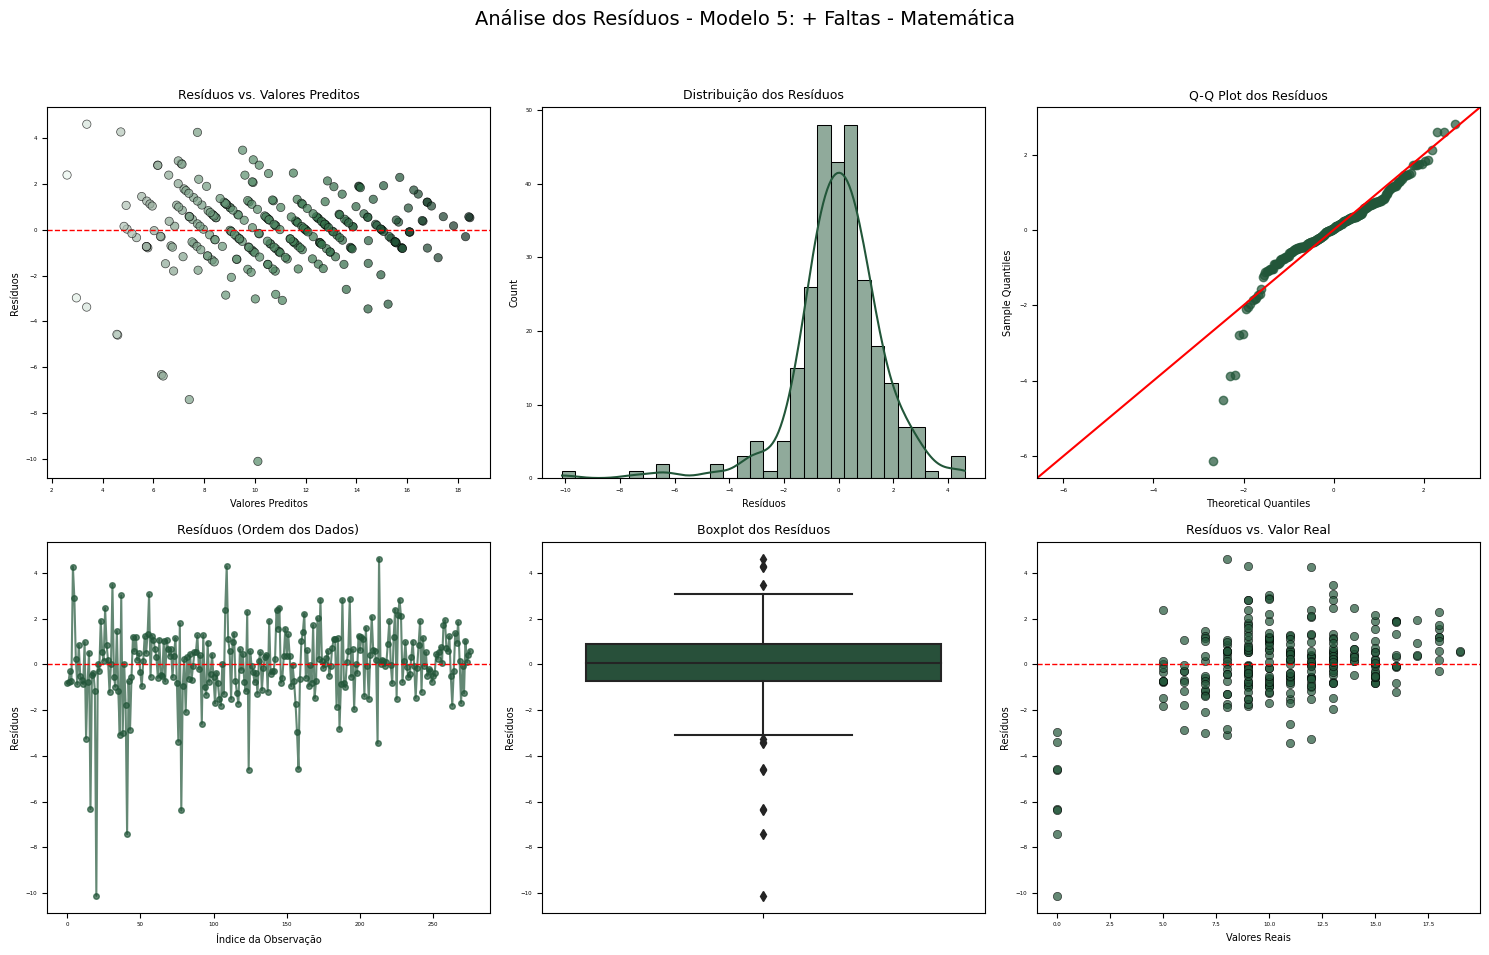

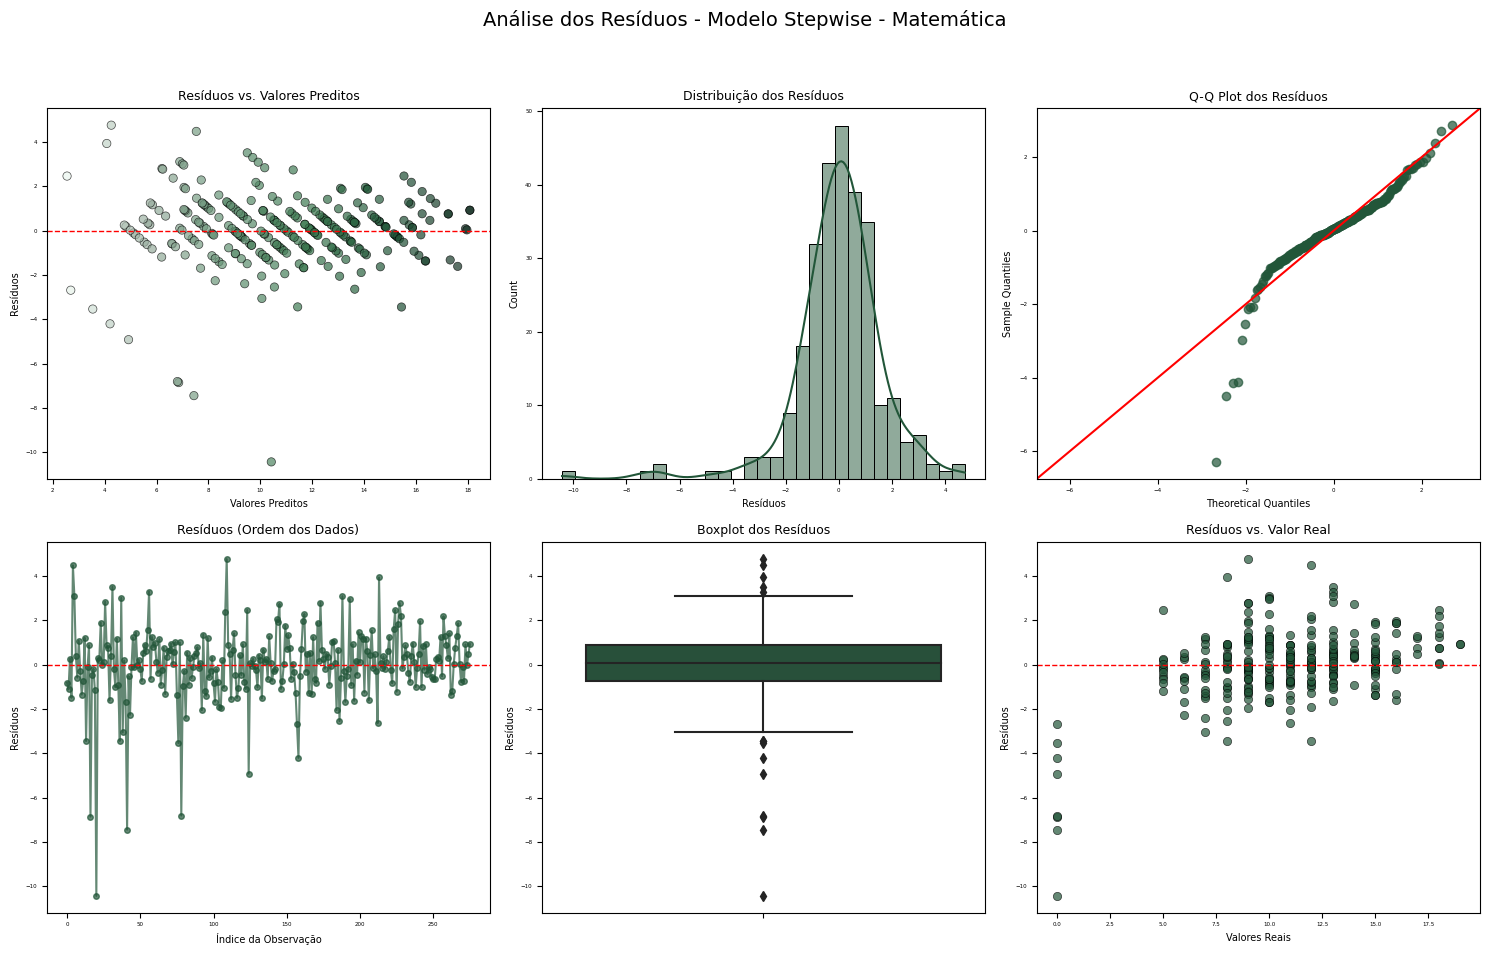

,Modelo,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,Modelo 1: Simples,-0.0,0.8752,0.0,Não,0.0252,Não,1.7687,Ausente (aprox.),5
1,Modelo 2: + Não-Notas,0.0,0.9040,0.0,Não,0.0007,Não,1.9437,Ausente (aprox.),5
2,Modelo 3: p-valores,-0.0,0.8907,0.0,Não,0.0012,Não,1.9084,Ausente (aprox.),4
3,Modelo 4: Redução Multicol.,-0.0,0.8907,0.0,Não,0.0012,Não,1.9084,Ausente (aprox.),4
4,Modelo 5: + Faltas,0.0,0.8947,0.0,Não,0.0010,Não,1.9084,Ausente (aprox.),4
5,Modelo Stepwise,-0.0,0.8802,0.0,Não,0.0041,Não,1.9070,Ausente (aprox.),4


In [22]:
resultados_residuos = []

resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_1.predict(), 'Modelo 1: Simples', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_2.predict(), 'Modelo 2: + Não-Notas', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_3.predict(), 'Modelo 3: p-valores', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_4.predict(), 'Modelo 4: Redução Multicol.', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_5.predict(), 'Modelo 5: + Faltas', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_step.predict(), 'Modelo Stepwise', materia))

df_residuos = pd.DataFrame(resultados_residuos)
df_residuos

# 5. Análise dos Fatores Associados à Nota Final

**Objetivo:** Investigar a contribuição de fatores socioeconômicos e escolares no desempenho final dos alunos (nota_final), a partir de regressões lineares com e sem a inclusão de notas parciais. A análise busca identificar quais atributos mantêm impacto estatisticamente significativo mesmo após o controle pelas notas anteriores.



## 5.1 Preparação da base para regressão
- Filtragem de variáveis relevantes
- Exclusão de variáveis-alvo derivadas ou colineares
- Inclusão condicional de `nota1` e `nota2` nas versões com notas


In [23]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao'],target_column='nota_final')

Removendo colunas: ['aprovacao']
Shape final do DataFrame preparado: (276, 42)


In [24]:

# Define target e colunas
target_final = 'nota_final'

# Versão 1: somente variáveis não associadas diretamente às notas
variaveis_contexto = list(set(df_pp.columns) - set(['nota1', 'nota2', 'nota_final']))
X_contexto = df_pp[variaveis_contexto]
y_final = df_pp[target_final]


In [25]:
# Versão 2: com notas intermediárias
variaveis_com_notas = variaveis_contexto + ['nota1', 'nota2']
X_com_notas = df_pp[variaveis_com_notas]



## 5.2 Regressão com variáveis contextuais (sem notas)
Avalia o poder explicativo das variáveis socioeconômicas, familiares e escolares isoladamente na `nota_final`.


In [26]:

modelo_contexto, X_ctx, y_ctx = regressao_multipla(df_pp[variaveis_contexto + ['nota_final']], 
                                                   target='nota_final', 
                                                   variaveis=variaveis_contexto)



## 5.3 Regressão com variáveis contextuais + notas



In [27]:
# Avalia a robustez dos coeficientes contextuais após controle por `nota1` e `nota2`.

modelo_completo, X_full, y_full = regressao_multipla(df_pp[variaveis_com_notas + ['nota_final']], 
                                                     target='nota_final', 
                                                     variaveis=variaveis_com_notas)



 ## 5.4 Comparação entre os modelos



In [28]:
print('modelo contextual:\n', modelo_contexto.summary())

modelo contextual:
                             OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     3.055
Date:                Wed, 14 May 2025   Prob (F-statistic):           9.01e-08
Time:                        22:44:41   Log-Likelihood:                -754.51
No. Observations:                 276   AIC:                             1589.
Df Residuals:                     236   BIC:                             1734.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [29]:
#Tabela comparativa com métricas de desempenho e número de variáveis significativas (p < 0.05).
modelos_5 = [modelo_completo, modelo_contexto]

df_comp_final = comparar_modelos_regressao(modelos=modelos_5,nomes=['Modelo Completo','Modelos Contexto'])

df_comp_final



,Modelo,R²,R² Ajustado,AIC,BIC,Log-Likelihood,F-statistic,RMSE,Nº Variáveis,Variáveis Significativas (p<0.05)
0,Modelo Completo,0.847942,0.821300,1185.956163,1338.012999,-550.978082,31.826609,1.934596,41,5
1,Modelos Contexto,0.335462,0.225644,1589.010139,1733.826174,-754.505070,3.054714,4.027154,39,6


## 5.5 Discussão dos Resultados

- Fatores contextuais, quando considerados isoladamente, apresentaram **baixo poder explicativo** para a `nota_final` (R² ajustado ≈ 0,23), evidenciando a limitação desses atributos em capturar o desempenho final dos estudantes.

- O modelo completo, com inclusão de `nota1` e `nota2`, apresentou R² ajustado acima de **0,82**, revelando que o desempenho anterior do aluno é o principal fator associado à `nota_final`.

- A variável `nota2` foi o preditor mais forte da `nota_final`, com coeficiente elevado e altamente significativo em todos os modelos avaliados.

- Algumas variáveis contextuais mantiveram significância estatística mesmo após o controle pelas notas anteriores, como:
  - `reprovacoes` (p < 0.001)
  - `idade` (p < 0.05)
  - `apoio_familiar`, `tamanho_familia` e `profissao_mae_Professor(a)` (p < 0.05)

- Esses achados indicam que fatores individuais e socioeducacionais podem exercer influência **marginal, mas consistente**, sobre o desempenho final.



## 6. Seleção de Atributos a partir do Modelo Contextual de Regressão

Nesta seção, buscou-se identificar os atributos mais relevantes para a predição do desempenho final dos alunos na disciplina de **Matemática**, a partir de um modelo de regressão linear múltipla com foco exclusivo em **variáveis contextuais** — excluindo, portanto, quaisquer medidas de nota intermediária. Essa abordagem foi adotada para evitar vazamento de informação em modelagens preditivas futuras da variável binária `aprovacao`.

A regressão foi ajustada utilizando `nota_final` como variável dependente, e o conjunto completo de atributos socioeconômicos, familiares, escolares e comportamentais como variáveis preditoras. O objetivo principal foi verificar a **significância estatística dos coeficientes**, a fim de subsidiar uma seleção de atributos com base empírica.

### Critérios de seleção adotados:

- Variáveis com **p-valor < 0.05** foram selecionadas diretamente;
- Variáveis com **0.05 ≤ p ≤ 0.10** foram consideradas relevantes de forma condicional, especialmente se reforçadas por embasamento teórico ou evidência em outras análises;
- Variáveis diretamente relacionadas às notas (`nota1`, `nota2`) foram propositalmente excluídas da regressão contextual.

### Resultados do Modelo Contextual — Matemática

| Variável                           | Coef.   | p-valor | Justificativa                                 |
| ---------------------------------- | ------- | ------- | ---------------------------------------------- |
| `reprovacoes`                      | -2.03   | 0.000   | Forte impacto negativo sobre o desempenho      |
| `genero_Mulher`                    | -1.46   | 0.016   | Diferença significativa entre gêneros          |
| `idade`                            | -0.64   | 0.021   | Relação negativa com o desempenho              |
| `apoio_familiar`                   | -1.20   | 0.036   | Indicador relevante do ambiente doméstico      |
| `tamanho_familia`                 | -1.22   | 0.035   | Sugere impacto estrutural na vida escolar      |
| `profissao_mae_Professor(a)`      | -2.60   | 0.042   | Relevância estatística e interpretativa        |
| `apoio_escolar`                   | -1.42   | 0.074   | Mantida por significância marginal e contexto  |
| `interesse_ensino_superior`       | 2.20    | 0.081   | Valor educativo; coerente com expectativa      |
| `alcool_dias_uteis`               | -0.71   | 0.090   | Indica possível interferência comportamental   |

Total de variáveis selecionadas: **9**


In [30]:
print(modelo_contexto.summary())


                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     3.055
Date:                Wed, 14 May 2025   Prob (F-statistic):           9.01e-08
Time:                        22:44:41   Log-Likelihood:                -754.51
No. Observations:                 276   AIC:                             1589.
Df Residuals:                     236   BIC:                             1734.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [31]:
selecao_atributos_regressao_mat = [
    'reprovacoes',
    'genero',
    'idade',
    'apoio_familiar',
    'tamanho_familia',
    'profissao_mae',
    'apoio_escolar',
    'interesse_ensino_superior',
    'alcool_dias_uteis'
]


In [32]:
variaveis_categoricas_nominais = [
    'escola', 
    'genero', 
    'endereco', 
    'status_parental', 
    'profissao_mae', 
    'profissao_pai', 
    'motivo_escolha_escola', 
    'responsavel_legal', 
    'apoio_escolar', 
    'apoio_familiar', 
    'aulas_particulares', 
    'atividades_extracurriculares', 
    'frequentou_creche', 
    'interesse_ensino_superior', 
    'acesso_internet', 
    'relacionamento_romantico',
    'tamanho_familia',

    ]

variaveis_categoricas_ordinais = [
    'escolaridade_mae', 
    'escolaridade_pai', 
    'relacao_familiar',
    'tempo_livre',      
    'frequencia_saidas',
    'saude',            
    'tempo_estudo',     
    'tempo_transporte',
    'alcool_dias_uteis',
    'alcool_fim_semana',
    'reprovacoes' 

    ]

variaveis_categoricas = variaveis_categoricas_nominais + variaveis_categoricas_ordinais


# 7. Seleção de Atributos a partir de Testes Estatísticos (Inferência)

Esta seção tem como objetivo identificar variáveis com associação estatística relevante ao desempenho escolar, a partir de testes inferenciais aplicados sobre variáveis categóricas. A análise é segmentada conforme a natureza das variáveis de entrada e da variável-alvo.



## 7.1. Testes para variáveis ordinais

Para as variáveis categóricas ordinais, optou-se por utilizar a `nota_final` como variável dependente, por conservar maior sensibilidade em relação à variação de desempenho. Aplicaram-se testes não paramétricos — correlação de Spearman e Kruskal-Wallis — para avaliar, respectivamente, a monotonicidade e diferenças entre grupos. 

Foram consideradas relevantes as variáveis com correlação ≥ 0.15 e p-valor < 0.05 em pelo menos um dos testes.


In [33]:
print('Matemática - Variáveis Categóricas ordinais \n')
df_ord = selecionar_ordinais_relevantes(df, variaveis_categoricas_ordinais, target='nota_final')


Matemática - Variáveis Categóricas ordinais 

Variáveis ordinais relevantes para explicabilidade do atributo 'nota_final'
  com base nos testes estatísticos:


,Variável,Correlação (Spearman),P-valor (Spearman),Estatística H (Kruskal),P-valor (Kruskal)
10,reprovacoes,-0.363,4.82e-10,39.091,1.66e-08
0,escolaridade_mae,0.227,0.0,17.092,0.002
1,escolaridade_pai,0.209,0.0,15.872,0.003
4,frequencia_saidas,-0.169,0.005,12.641,0.013
9,alcool_fim_semana,-0.145,0.016,7.596,0.108
8,alcool_dias_uteis,-0.137,0.023,5.742,0.219


In [34]:
variaveis_ordinais_relevantes = [
    'reprovacoes',
    'escolaridade_mae',
    'escolaridade_pai',
    'frequencia_saidas',
    'alcool_fim_semana'
]



## 7.2. Testes para variáveis nominais

As variáveis nominais foram analisadas em relação à variável binária `aprovacao`, com aplicação do teste de Qui-quadrado de independência e cálculo do V de Cramér como medida de associação. Foram selecionadas as variáveis com p-valor < 0.05 e V de Cramér ≥ 0.10, indicando associação estatisticamente significativa e força de relação relevante com a taxa de aprovação.


In [40]:
print('Matemática - Variáveis Categóricas Nominais \n')

df_nom =selecionar_nominais_relevantes(df, categoria_de_interesse='aprovacao', variaveis_categoricas=variaveis_categoricas,c_c=0.1)

Matemática - Variáveis Categóricas Nominais 

Variáveis com P-Value < 0.05 e V de Cramér > 0.10:


,Variable,P-Value,V de Cramér
1,reprovacoes,5.22e-08,0.365
0,frequencia_saidas,0.015,0.212


In [36]:
variaveis_nominais_relevantes = [
    'reprovacoes',
    'frequencia_saidas'
]


## 7.3 Construção da Lista de Atributos com base em inferência estatística

A seleção de atributos por inferência estatística baseou-se na identificação de variáveis categóricas com associação estatisticamente significativa ao desempenho escolar, conforme segue:

- Variáveis ordinais foram avaliadas com correlação de Spearman e teste de Kruskal-Wallis em relação à nota final.

- Variáveis nominais foram analisadas via teste qui-quadrado e V de Cramér em relação à aprovação.

- Combinando ambos os conjuntos e eliminando duplicatas, obteve-se uma lista de 5 atributos relevantes com força de associação estatística adequada.

Além disso, a variável faltas foi incluída por justificativa pedagógica e analítica: trata-se de um fator de grande relevância educacional, com indícios de impacto sobre o desempenho em análises exploratórias, ainda que não tenha se destacado diretamente nos testes estatísticos.

In [37]:
variaveis_estatisticas_relevantes = sorted(set(
    variaveis_ordinais_relevantes + variaveis_nominais_relevantes
))
len(variaveis_estatisticas_relevantes)

5

In [38]:
variaveis_estatisticas_relevantes

['alcool_fim_semana',
 'escolaridade_mae',
 'escolaridade_pai',
 'frequencia_saidas',
 'reprovacoes']

In [39]:
selecao_inferencia = [
    'reprovacoes',
    'frequencia_saidas',
    'escolaridade_mae',
    'escolaridade_pai',
    'alcool_fim_semana',
    'faltas'
]
